In [1]:
import torch
from torch.nn import Linear, Parameter
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, softmax, dropout_edge
from torch_geometric.data import Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import rearrange
from typing import Literal
import networkx as nx
import copy
import matplotlib.cm as cm
from utils import draw_graph

# Graph Neural Networks 

### Disclaimer

What is presented here focuses on the **spatial graph (convolutional) neural networks**, which only represent a subset of the GNNs architectures. 

The other major cathegory of GNNs is **spectral graph convolutional neural networks** and their approximations that use  polynomial  filters (e.g. ChebNet (Defferrard et al., 2016), BernNet (He et al., 2021)).

Check out the famous GCN paper to understand the connection between the two: "Semi-supervised classification with Graph Convolutional Network" by Kipft & Welling (2016).

### Base concepts

- A graph $\mathcal{G}=(X,A)$ is an object representing a set of entities (or nodes) $\{i\}_{i=0}^{N}$, their features grouped into a feature matrix $X\in \mathbb{R}^{N\times d_x}$, and an adjacency matrix $A\in \mathbb{R}^{N\times N}$, encoding their relationships.

- $\mathcal{G}_1=(X,A)$ is the same graph as $\mathcal{G}_2=(PX, PAP^T)$ for any permutation matrix $P$.

- An element $a_{ij}$ of $A$ is set to $1$ if there is an edge (a "relationship") between entity $i$ and entity $j$, otherwise it is set to $0$.

- With GNNs, we aim to learn a function $$H=f(X,A) \in \mathbb{R}^{N\times d_h}$$ that learns latent representations $H$ of the nodes taking into account the relationships that exist between them. That is, we want to design a model whose predictions are conditioned on the connectivity. 

- Note the difference with a classical FFNN: 
    - A FFNN would treat each entity individually to learn $h_i=f(x_i)$
    - A GNN considers the connectivity of the graph $h_i = f(X, A)_i$ as an **inductive bias**: the assumption that a graph's structure and node relationships (such as locality and permutation invariance) are key to understanding and predicting its properties.

- Function $f$ must be **permutation equivariant**, since the node features are grouped into $X$ in an arbitrary order (i.e, if $X[i]$ are the features of node $i$, $H[i]$ will be its latent features.).

- Internally, nodes must propagate/diffuse information using a **permutation invariant** function that operates on a certain neighborhood $\mathcal{N}_i$ for each node $i$ (i.e, no matter the order in which I process the neighborhood, the output will be the same).

- Typically the 1-hop neighborood is considered for $\mathcal{N}_i$. To increase the receptive field of the network, we usually stack layers: 
$$
\begin{aligned}
H^{(0)} &= X \\ 
H^{(k)} & = f^{(k)}(H^{(k-1)}, A)
\end{aligned}
$$

With a GNN with $k$ layers, nodes at a distance larger than $k$ are unaware of eachother. If there is useful latent interaction for the downstream taks between nodes at a greater distance than $k$, such network is not able to learn them. 



- The typical tasks are:
    - Node-level tasks: learn something about individual nodes
    - Graph-level tasks: learn something about the whole graph
    - Edge-level tasks: infer something about existing relationships


**Node classification/regression**

  <img src="./imgs/node_task.png" alt="nt" width="800"/>


**Graph classification/regression**

  <img src="./imgs/graph_task.png" alt="gt" width="1000"/>


**Link prediction**

  <img src="./imgs/edge_task.png" alt="et" width="800"/>

### Other concepts

- GNNs have some shortcomings, such as:
    - Over-smoothing: convolutions act as a low-pass filter, and deep networks risk to produce indistinguishable features for each node. 
    - Over-squashing: as the network becomes deep, an exponentially growing amount of information needs to be compressed into finite vectors. This makes learning interactions between distant nodes quite difficult. 

- The graph does not need to be know as a prior. It can be learned alongside the downstream task.

- As an alterative to stacks of layers that consider the 1-hop neighborhood, one could use powers of a graph shift-operator $\tilde{A}$ (eg, the normalized Laplacian) to propagate information to a larger neighborhood in a single layer using polynomial filters (see `graph_shift.ipynb`): 
$$
H = \sigma \left( \sum_{k=0}^K \tilde{A}^k X \Theta^{(k)} \right)
$$

- Fun fact: Transformers can be seen as a special case of attentional GNNs that use a full graph! See this nice blog post: [Transformers are graph neural networks](https://thegradient.pub/transformers-are-graph-neural-networks/)

# Message Passing


A typical GNN layer $h_i=f(X,A)_i$ can be written in the **message passing (MP)** form:

$$h_i = \phi_{up} \left(x_i, \bigoplus_{j \in \mathcal{N}_i} \phi_{msg}(x_i,x_j)\right)$$

where $\phi_{up}$ and $\phi_{msg}$ are learnable functions (**update** and **message** function respectively). $\bigoplus$ instead is some kind of permutation-invariant **aggregation** function (e.g sum, mean, max). This is important because graphs do not have an order, and by processing edges in a different order, the output should be the same.

If there are edge features, those can be included in the message computattion: $\phi_{msg}(x_i,x_j, e_{ij})$

#### Intuition: 

- Each node collects *messages* computed by a learnable function for each of its neighbours (eg, those that are 1 edge away).
- As the order and number of messages should not matter, the receiving node aggregates them into a single vector (eg sum, mean, max).
- Given their previous representation and the aggregated messages, each node updates its new latent representation.


<p align="center">
  <img src="./imgs/message_passing.png" alt="mp" width="400"/>
</p>

##### The connection between convolutional and message passing layers

Note the similarity between a MP layer: 

$$h_i = \phi_{up} \left(x_i, \bigoplus_{j \in \mathcal{N}_i} \phi_{msg}(x_i,x_j)\right)$$


and a convolutional layer (see `graph_shift.ipynb`):

$$
h_i = \phi_{up} \left(x_i, \bigoplus_{j \in \mathcal{N}_i} \tilde{a}_{ij} x_jW\right)
$$

While the convolutional layer performs a **non-trainable weighted average** of the transformed neighbouring features, the message passing allows to **learn whole vectors** to be exchanged between nodes. 

In fact: $\{\text{Conv. layers} \} \sub \{ \text{MP layers}\}$

### Pytorch geometric (PyG) 

It is a library consisting of various methods for deep learning on graphs (known as geometric deep learning).

PyG reflects the message passing formulation. To define a custom layer we need to:
- define the **aggregation** type $\bigoplus$. It can be `sum`, `mean` or `max`.
- implement the **message** function $\phi_{msg}$ (as well as the usual forward function). `forward` function should call `MessagePassing.propagate`, which will start propagating the messages and can take any extra argument needed to compute your message. When implementing `MessagePassing.message`, we have access to all arguments passed to `propagate`. Those arguments can additionally be mapped to the respective sending or receiving nodes by appending `_i` or `_j` to the variable name. For example we can map a `x` which is a $[N,d_x]$ tensor, into `x_i` with shape $[E,d_x]$. Note that we can use any naming for the variables!
- implement the **update** function $\phi_{up}$ (optional). It takes the aggregated outputs of the messages and any argument that was passed to `propagate()`. 

The adjacency matrix $A$ of the graph is stored in its sparse form, by means of a $2\times E$ tensor, i.e, each entry is an $(i,j)$ pair representing an edge.

Batching multiple graphs is possible by grouping the graphs into a single graph with disconnected components. There is then an index assigning each element to its corresponding graph in the batch.

$$
\mathbf{A}_{\text{batched}} =
\begin{bmatrix}
A_1 & 0 & 0 & \cdots & 0 \\
0 & A_2 & 0 & \cdots & 0 \\
0 & 0 & A_3 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & A_n
\end{bmatrix}

\mathbf{X}_{\text{batched}} =
\begin{bmatrix}
X_1 \\
X_2 \\
X_3 \\
\vdots \\
X_n \\
\end{bmatrix}
$$

In [142]:
edge_index = torch.tensor([[0, 1],[0,2],[0,3],[1,0],[1,2],[2,1],[2,0],[3,0]], dtype=torch.long)
edge_index = edge_index.T

x = torch.tensor([[0,1], [1,1], [2,1], [3,1]], dtype=torch.float)

edge_attr = torch.tensor([1,2,3,4,5,6,7,8], dtype=torch.float32).reshape(-1,1)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Print the created graph
print(data)
print(edge_index)
print(data.validate())

Data(x=[4, 2], edge_index=[2, 8], edge_attr=[8, 1])
tensor([[0, 0, 0, 1, 1, 2, 2, 3],
        [1, 2, 3, 0, 2, 1, 0, 0]])
True


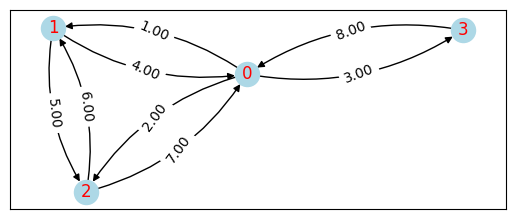

In [316]:
draw_graph(edge_index=edge_index, edge_values=edge_attr.reshape(-1))

In [317]:
class dummy_GNN(MessagePassing):
    def __init__(self, feat_shape, out_shape, edge_shape, aggr = "add", **kwargs):
        super().__init__(aggr, **kwargs)

        self.edge_encoder = torch.nn.Linear(edge_shape, out_shape)
        self.node_encoder = torch.nn.Linear(feat_shape, out_shape)

    def forward(self, x, edge_index, edge_attr):
        print("-"*50)
        print(f'[forward] \t Shape of x: \t\t{x.shape}')
        print(f'[forward] \t Shape of edge_index: \t{edge_index.shape}')

        # bring node features in another space with a linear transformation 
        x = self.node_encoder(x) 
        print(f'[forward] \t Shape of encoded x: \t{x.shape}') 
        
        # start propagating the messages
        out = self.propagate(edge_index=edge_index, x=x, edge_attr=edge_attr)
        
        print(f'[forward] \t Shape of out: \t\t{out.shape}')
        print("-"*50)
    

    def message(self, x_i, x_j, x, edge_index, edge_attr):
        print("-"*50)
        print(f'[message]\t Shape of x_i: \t\t{x_i.shape}')
        print(f'[message]\t Shape of x: \t\t{x.shape}')
        print(f'[message]\t Shape of edge_attr: \t{edge_attr.shape}')
        print("-"*50)
        return x_i + x_j + self.edge_encoder(edge_attr)# dummy message


    def update(self, aggr_out, x):
        print("-"*50)
        print(f'[update]\t Shape of aggr_out: \t{aggr_out.shape}')
        print(f'[update]\t Shape of x: \t\t{x.shape}')
        print("-"*50)
        return aggr_out + x # like a skip connection

In [318]:
gnn = dummy_GNN(feat_shape=2, edge_shape=1, out_shape=6)
gnn(data.x, data.edge_index, data.edge_attr)

--------------------------------------------------
[forward] 	 Shape of x: 		torch.Size([4, 2])
[forward] 	 Shape of edge_index: 	torch.Size([2, 8])
[forward] 	 Shape of encoded x: 	torch.Size([4, 6])
--------------------------------------------------
[message]	 Shape of x_i: 		torch.Size([8, 6])
[message]	 Shape of x: 		torch.Size([4, 6])
[message]	 Shape of edge_attr: 	torch.Size([8, 1])
--------------------------------------------------
--------------------------------------------------
[update]	 Shape of aggr_out: 	torch.Size([4, 6])
[update]	 Shape of x: 		torch.Size([4, 6])
--------------------------------------------------
[forward] 	 Shape of out: 		torch.Size([4, 6])
--------------------------------------------------


### Example of GNN layer: Graph Attention Networks (GAT) by Veličković et. al, 2018

First, features are linearly transformed via a learnable weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$.

Then we compute masked self-attention coefficients. It is masked since only connected nodes are considered, and it is self-attentive because nodes attend to themselves and the neighbors.

$$e_{ij} = \text{a}(\mathbf{W}h_{i}, \mathbf{W}h_j), \quad \text{a}: \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}$$

$$\alpha_{ij}=\text{softmax}_j(e_{ij})= \frac{\exp(e_{ij})}{\sum_{k\in \mathcal{N}_i} \exp(e_{ik})}$$

In the original paper proposes the following attention mechanism:

$$\alpha_{ij}= \frac{\exp\left(\text{LeakyReLU}(a^T[\mathbf{W}h_i \mid\mid \mathbf{W}h_j])\right)}{\sum_{k\in \mathcal{N}_i} \exp\left(\text{LeakyReLU}(a^T[\mathbf{W}h_i \mid\mid \mathbf{W}h_k])\right)}, \quad a \in \mathbb{R}^{2F'}$$

#### TLDR: 

This layer is spatial GNN layer where the diffusion/propagation/message-passing uses an attention mechanism to scale the (transformed) features of neighboring nodes before aggregating them. 

In the message-passing framework we have:

$$h_i = \text{LeakyReLU} \left(\sum_{j \in \mathcal{N}_i} \text{att}(x_i,x_j)\mathbf{W}x_j\right)$$

- The message function: $\phi_{msg}(x_i, x_j) = \text{att}(x_i,x_j)\mathbf{W}x_j$
- The aggregation function: $\bigoplus = \sum$
- The update function: $\phi_{up} \left( \cdot \right) = \text{LeakyReLU} \left( \cdot \right)$

Attentional GNNs are very similar to convolutional GNNs, with the additional ability to perform a **learnable** weighted average, as opposed to a non-learnable weighted average which depends on the graph's connectivity.

<!-- $$h_i = \phi_{up} \left(x_i, \bigoplus_{j \in \mathcal{N}_i} \phi_{msg}(x_i,x_j)\right)$$ -->

In [156]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, 
                 dropout=0.1, 
                 negative_slope: float = 0.2, 
                 attention_heads: int = 1,
                 handle_attention_heads: Literal['concat', 'sum'] = 'concat',
                 **kwargs):
        super(GATConv, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.negative_slope = negative_slope
        self.attention_heads = attention_heads
        self.handle_attention_heads = handle_attention_heads

        self.weight = torch.nn.Parameter(torch.Tensor(in_channels, out_channels*attention_heads))
        self.att = torch.nn.Parameter(torch.Tensor(2*out_channels, 1*attention_heads))

        self.up = torch.nn.LeakyReLU(negative_slope=self.negative_slope)


        self.reset_parameters()
        

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.att)

        print('Initialized parameters.')

    def forward(self, x, edge_index, plot_attentions=False):
        x_ = torch.mm(x, self.weight) # Apply transformation F -> F' to all nodes features
        x_ = F.dropout(x_, p=self.dropout, training=self.training) # Dropnout never hurts to slow down the overfit 
        # edge_index, _ = dropout_edge(edge_index, p=self.dropout) # we could also drop out some edges
        out = self.propagate(edge_index=edge_index, x=x_, plot_attentions=plot_attentions) # Start propagating messages

        return out

    def message(self, x_i, x_j, edge_index, plot_attentions=False):
        # Concatenate src & tgt features
        
        # x_j and x_i have shape [E, out*heads] 
        # x_j = [h1, h2, h3, ...]
        # x_i = [h1, h2, h3, ...]

        xs = []
        for h in range(self.attention_heads):
            x_ = torch.cat([x_i[:,h*self.out_channels:(h+1)*self.out_channels],
                            x_j[:,h*self.out_channels:(h+1)*self.out_channels]], dim=1)
            xs.append(x_)

        xs = torch.stack(xs, dim=1)
        # xs = F.dropout(xs, p=self.dropout, training=self.training)


        e_ij = torch.einsum('ehf,fh->eh', xs, self.att) # Compute the attention coeffs for each head

        # shape [E, H]
        attention_scalars = F.leaky_relu(e_ij, self.negative_slope)
        attention_scalars = softmax(attention_scalars, edge_index[0]) # Normalize them for each neighborhood

        if plot_attentions:
            draw_graph(edge_index=edge_index, edge_values=attention_scalars[:,0].detach())

        # attention_scalars = F.dropout(attention_scalars, p=self.dropout, training=self.training)

        # For each edge, scale each receiving node feature by the corrisponding attention coeffs 
        x_with_att = torch.einsum('EH, EHF->EHF', attention_scalars, xs[...,self.out_channels:]) # msg_ij = att(x_i,x_j)(W x_j)


        if self.handle_attention_heads == 'concat':
            return x_with_att.reshape(x_with_att.shape[0], -1)
        elif self.handle_attention_heads == 'sum':
            return x_with_att.sum(dim=-2)
        else:
            raise NotImplementedError('invalid handling of attentions heads')

    
    def update(self, aggr_out):
        # Apply an activation to the aggregated messages before outputting the new features.
        # Here we could add a skip connection as self.up(aggr_out + x)
        # Every variable passed to propagate() can be accessed here 
        out = self.up(aggr_out)
        return out


This is an untrained GAT layer. On each edge $(i,j)$ we plot the attention coefficients $\text{att}(x_i, x_j)$. 

Note how $\sum_{j \in \mathcal{N}_i}\text{att}(x_i, x_j)=1$ for each node $i$ and its neighborhood $\mathcal{N}_i$.

Initialized parameters.


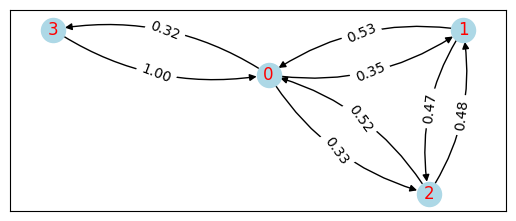

In [157]:
dummy_GATConv = GATConv(in_channels=2, out_channels=3, attention_heads=4)
h = dummy_GATConv(data.x, data.edge_index, plot_attentions=True) # This is h=f(x,A)

# Semi-supervised node classification

We will put our GAT layer to the test with a semi-supervised node classification task on the Cora citation network, a well known benchmark for graph representation learning. 

Each node $i$ has features $x_i \in \mathbb{R}^{1433}$ representing a bag-of-word contained in the document. Only a small subset of nodes are labelled, however this is not an issue, we can perform message-passing on our graph and only compute the loss function on the labelled nodes. 

As we will see there are only $140$ labelled nodes in the training set, out of the $2700+$ nodes in the whole graph. 

For each node $i$, the task is to predict its label $y_i \in \{0, \dots, 6\}$.

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [139]:
print(f'There are {(dataset[0].train_mask).sum().item()} labelled nodes for training.')
print(f'There are {(dataset[0].val_mask).sum().item()} labelled nodes for validation.')
print(f'There are {(dataset[0].test_mask).sum().item()} labelled nodes for testing.')

print(f'There are {(dataset[0].num_nodes)} nodes in the overall graph.')
print(f'There are {(dataset[0].num_edges)} edges in the overall graph.')

There are 140 labelled nodes for training.
There are 500 labelled nodes for validation.
There are 1000 labelled nodes for testing.
There are 2708 nodes in the overall graph.
There are 10556 edges in the overall graph.


We can stack together some GAT layers, to make a GAT model:

$$
\begin{aligned}
H^{(0)} &= X \\ 
H^{(k)} & = \text{GatLayer}^{(k)}(H^{(k-1)}, A)
\end{aligned}
$$

In [7]:
class GATModel(torch.nn.Module):
    def __init__(self, hidden_size: int,
                 num_layers: int = 1,
                 attention_heads=1,
                 dropout = 0):
        super().__init__()
        torch.manual_seed(12345)


        self.mpnns = torch.nn.ModuleList()
        self.skip_conn = torch.nn.ModuleList()
        self.classifier = Linear(hidden_size*attention_heads, dataset.num_classes)
        self.dropout = torch.nn.Dropout(p=dropout)

        for l in range(num_layers):
            in_size = dataset.num_features if l == 0 else hidden_size*attention_heads

            mpnn = GATConv(in_size, hidden_size, dropout=dropout, attention_heads=attention_heads)
            self.mpnns.append(mpnn)


    def forward(self, x, edge_index):
         
        x = self.dropout(x)
        for i,mpnn in enumerate(self.mpnns):
            x = mpnn(x, edge_index)


        out = self.classifier(x)
        return out


In [ ]:
data = dataset[0] # there is only 1 graph 

## Let's train the GAT model:

In [14]:
class EarlyStopping:

    def __init__(self, patience=10, mode: Literal['max', 'min'] = 'min'):
        self.patience = patience

        self.best_score = float('inf') if mode == 'min' else float('-inf')
        self.best_model = None
        self.mode = mode

        self.counter = 0
        self.call_counter = 0
        self.best_score_iteration = 0

    def better(self, new, current):
        if self.mode == 'min':
            return new < current
        return new > current

    def __call__(self, score, model):
        self.call_counter += 1

        if self.better(new=score, current=self.best_score):
            self.best_score = score
            self.best_model = copy.deepcopy(model)
            self.counter = 0
            self.best_score_iteration = self.call_counter
            return False
        
        self.counter += 1

        if self.counter > self.patience:
            return True
        return False
        

In [555]:
model = GATModel(hidden_size=8, attention_heads=8, num_layers=2, dropout=0.2)

early_stopper = EarlyStopping(patience=50, mode='min')
model.eval()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.003, weight_decay=5e-4) 

Initialized parameters.
Initialized parameters.


In [ ]:

losses = []
accuracies = []
val_losses = []
val_accuracies = []

def train():
      model.train()
      optimizer.zero_grad()
      
      out = model(data.x, data.edge_index) # H = f(X, A) 

      pred = out.argmax(dim=1)
      train_correct = pred[data.train_mask] == data.y[data.train_mask]
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
      accuracies.append(train_acc)

      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      with torch.no_grad():
            out = model(data.x, data.edge_index)

            pred = out.argmax(dim=1)
            test_correct = pred[mask] == data.y[mask]
            test_acc = int(test_correct.sum()) / int(mask.sum())

            loss = criterion(out[mask], data.y[mask])
            val_losses.append(loss.item())
            val_accuracies.append(test_acc)
            return test_acc, loss


In [557]:
for epoch in range(1, 2000):
    train_loss = train()
    val_acc, val_loss = test(data.val_mask)

    if early_stopper(val_loss, model):
         print(f'Early stopped. Best iteration = {early_stopper.best_score_iteration} with score = {early_stopper.best_score}')
         break
    if epoch % 10 == 0:
      print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - '
            f'Validation accuracy: {val_acc * 100:.2f}%')

Epoch: 010 - Training loss: 1.9317 - Validation accuracy: 7.40%
Epoch: 020 - Training loss: 1.8672 - Validation accuracy: 42.80%
Epoch: 030 - Training loss: 1.6942 - Validation accuracy: 60.60%
Epoch: 040 - Training loss: 1.3487 - Validation accuracy: 72.80%
Epoch: 050 - Training loss: 0.9264 - Validation accuracy: 76.80%
Epoch: 060 - Training loss: 0.5167 - Validation accuracy: 78.40%
Epoch: 070 - Training loss: 0.2943 - Validation accuracy: 79.40%
Epoch: 080 - Training loss: 0.1770 - Validation accuracy: 80.60%
Epoch: 090 - Training loss: 0.1198 - Validation accuracy: 79.40%
Epoch: 100 - Training loss: 0.0885 - Validation accuracy: 79.60%
Epoch: 110 - Training loss: 0.0824 - Validation accuracy: 79.40%
Epoch: 120 - Training loss: 0.0737 - Validation accuracy: 80.20%
Epoch: 130 - Training loss: 0.0839 - Validation accuracy: 78.00%
Epoch: 140 - Training loss: 0.0565 - Validation accuracy: 79.20%
Epoch: 150 - Training loss: 0.0504 - Validation accuracy: 78.00%
Epoch: 160 - Training loss

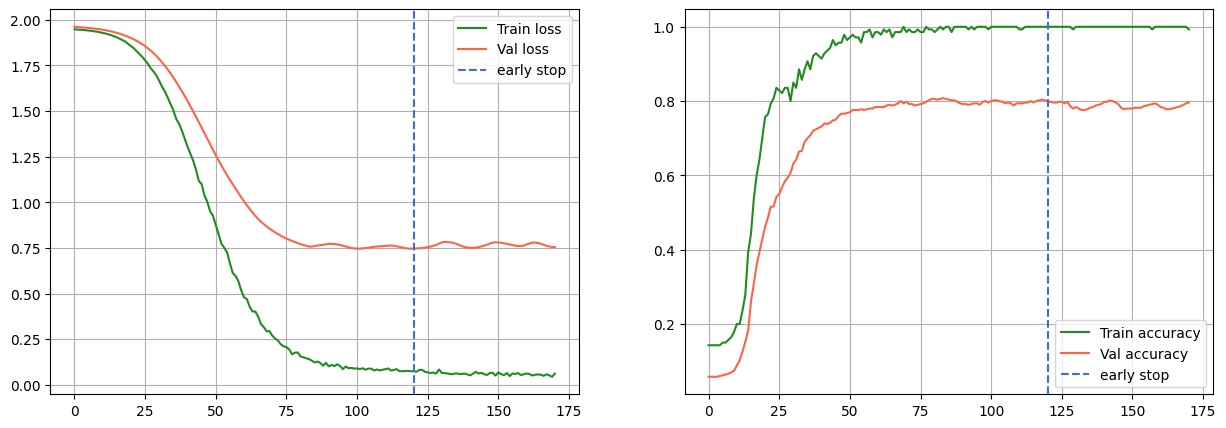

In [558]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(losses, label='Train loss', color='forestgreen')
axes[0].plot(val_losses, label='Val loss', color='tomato')
axes[1].plot(accuracies, label='Train accuracy', color='forestgreen')
axes[1].plot(val_accuracies, label='Val accuracy', color='tomato')
axes[0].axvline(x=early_stopper.best_score_iteration, color='royalblue', linestyle='--', label='early stop')
axes[1].axvline(x=early_stopper.best_score_iteration, color='royalblue', linestyle='--', label='early stop')

axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()

In [559]:
test_acc, test_loss = test(data.test_mask)
print(f'We obtained a test accuracy of {test_acc* 100} %')

We obtained a test accuracy of 76.9 %


### Good news:

PyG comes with pre-defined GNN model and layer architectures and we do not always need to implement everything at the MessagePassing layer level. 

### How does it compare with a FFNN?

In [98]:
class MLP(torch.nn.Module):

    def __init__(self, in_size, hidden_sizes, out_size, p=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.layers = torch.nn.ModuleList()
        for hs in hidden_sizes:
            self.layers.append(torch.nn.Linear(in_size, hs))
            self.layers.append(torch.nn.Tanh())
            self.layers.append(torch.nn.Dropout(p=p))

            in_size = hs
        
        self.classifier = torch.nn.Linear(hidden_sizes[-1], out_size)

    def forward(self, x):
        for l in self.layers:
            x = l(x)

        return self.classifier(x)


In [ ]:
# Try it yourself, it seems that a shallow mlp gives the best result. 
mlp = MLP(dataset.num_features, hidden_sizes=[16], out_size=dataset.num_classes, p=0.2)

losses = []
accuracies = []
val_losses = []
val_accuracies = []

def train_mlp():
      mlp.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      out = mlp(data.x)

      pred = out.argmax(dim=1)
      train_correct = pred[data.train_mask] == data.y[data.train_mask]
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
      accuracies.append(train_acc)

      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      return loss

def test_mlp(mask):
      mlp.eval()
      with torch.no_grad():
            out = mlp(data.x)

            pred = out.argmax(dim=1)
            test_correct = pred[mask] == data.y[mask]
            test_acc = int(test_correct.sum()) / int(mask.sum())

            loss = criterion(out[mask], data.y[mask])
            val_losses.append(loss.item())
            val_accuracies.append(test_acc)
            return test_acc, loss

In [119]:
early_stopper = EarlyStopping(patience=50, mode='min')
mlp.eval()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(),
                             lr=0.008, weight_decay=5e-4) 

In [120]:
for epoch in range(1, 2000):
    train_loss = train_mlp()
    val_acc, val_loss = test_mlp(data.val_mask)

    if early_stopper(val_loss, mlp):
         print(f'Early stopped. Best iteration = {early_stopper.best_score_iteration} with score = {early_stopper.best_score}')
         break
    if epoch % 10 == 0:
      print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - '
            f'Validation accuracy: {val_acc * 100:.2f}%')

Epoch: 010 - Training loss: 1.8664 - Validation accuracy: 19.80%
Epoch: 020 - Training loss: 1.7073 - Validation accuracy: 55.40%
Epoch: 030 - Training loss: 1.4787 - Validation accuracy: 47.80%
Epoch: 040 - Training loss: 1.1702 - Validation accuracy: 51.60%
Epoch: 050 - Training loss: 0.9050 - Validation accuracy: 54.60%
Epoch: 060 - Training loss: 0.6628 - Validation accuracy: 54.40%
Epoch: 070 - Training loss: 0.4952 - Validation accuracy: 54.60%
Epoch: 080 - Training loss: 0.4194 - Validation accuracy: 57.40%
Epoch: 090 - Training loss: 0.3207 - Validation accuracy: 56.80%
Epoch: 100 - Training loss: 0.2837 - Validation accuracy: 57.00%
Epoch: 110 - Training loss: 0.2679 - Validation accuracy: 57.40%
Epoch: 120 - Training loss: 0.2329 - Validation accuracy: 57.40%
Epoch: 130 - Training loss: 0.2131 - Validation accuracy: 57.80%
Epoch: 140 - Training loss: 0.2157 - Validation accuracy: 56.80%
Epoch: 150 - Training loss: 0.1889 - Validation accuracy: 57.20%
Epoch: 160 - Training los

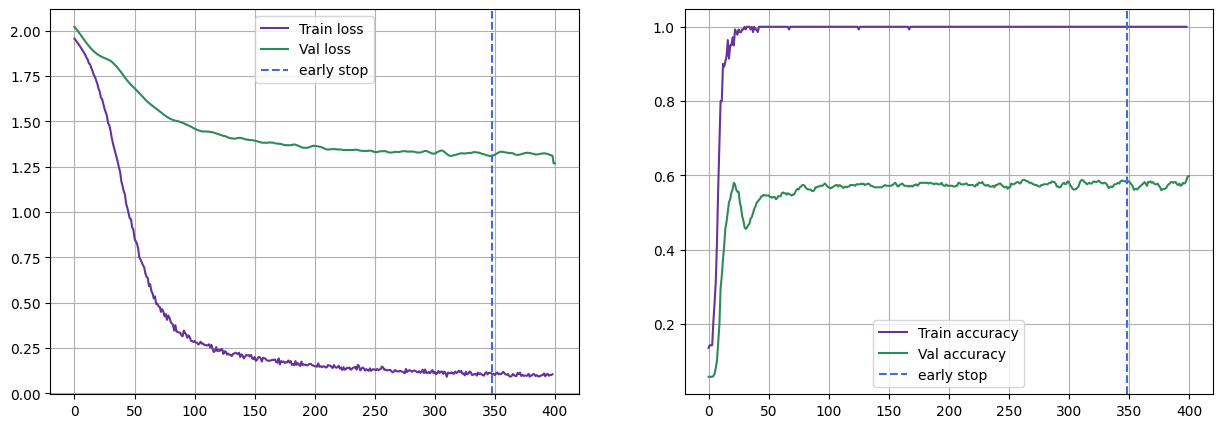

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(losses, label='Train loss', color='rebeccapurple')
axes[0].plot(val_losses, label='Val loss', color='seagreen')
axes[1].plot(accuracies, label='Train accuracy', color='rebeccapurple')
axes[1].plot(val_accuracies, label='Val accuracy', color='seagreen')
axes[0].axvline(x=early_stopper.best_score_iteration, color='royalblue', linestyle='--', label='early stop')
axes[1].axvline(x=early_stopper.best_score_iteration, color='royalblue', linestyle='--', label='early stop')

axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()

In [123]:
test_acc, test_loss = test_mlp(data.test_mask)
print(f'The MLP obtained a test accuracy of {test_acc* 100} %')

The MLP obtained a test accuracy of 59.8 %


It seems that the inductive bias of the graph is helpful!

#### Do you like to read? Check these papers out:



In no particular order, here is a list of papers I consider important (by no means exhaustive):

- *"The Graph Neural Network Model"*, Scarselli et. al (2008)
- *"Relational inductive biases, deep learning, and graph networks"*, Battaglia et. al (2018)
- *"Neural Message Passing for Quantum Chemistry"*, Gilmer et. al (2017)
- *"Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering"*, Defferrard et. al (2016)
- *"Spectral Networks and Locally Connected Networks on Graphs"*, Bruna et. al (2013)
- *"Geometric Deep Learning Grids, Groups, Graphs, Geodesics, and Gauges"*, Bronstein et. al (2021)

You made it till the end! Thanks for reading. 